In [1]:
from bnn.data import category_examples, augment_gamma, test_train_data, test_train_batch_data
from bnn.util import open_pickle_file
from bnn.predict import predict_on_data

from keras import backend as K
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import math

Using TensorFlow backend.


In [2]:
(train_images, _), (test_images, _) = cifar10.load_data()

In [3]:
(train_results, test_results) = open_pickle_file('predictions/resnet50_cifar10/results.p')

Unpickling file predictions/resnet50_cifar10/results.p


In [4]:
test_results[0]

{'aleatoric_uncertainty': 1.2480079,
 'epistemic_uncertainty': 1.096512,
 'is_correct': 0,
 'label': 3,
 'label_expanded': array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'logits_raw': array([ 0.66903812, -1.08939672,  3.53100395,  2.96074462, -0.04953169,
         0.3959001 ,  0.00894696, -4.6429863 ,  0.28723681,  1.43192542], dtype=float32),
 'softmax': 2,
 'softmax_raw': array([  3.01593021e-02,   5.19688241e-03,   5.27663767e-01,
          2.98329890e-01,   1.47011196e-02,   2.29508579e-02,
          1.55864535e-02,   1.48743653e-04,   2.05876622e-02,
          6.46753758e-02], dtype=float32)}

In [5]:
categories = category_examples('cifar10')

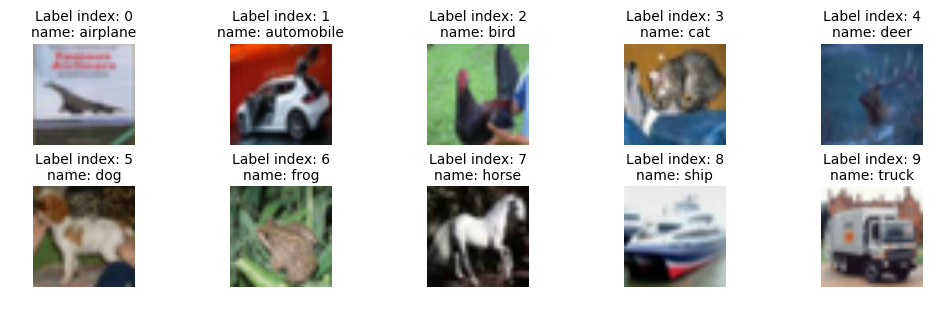

In [6]:
def display_categories(categories):
  f, axes = plt.subplots(int(len(categories)/5), 5, figsize=(10, 3))
  f.tight_layout()
  
  axes = np.reshape(axes, -1)
  
  for i in range(len(axes)):
    axes[i].imshow(categories[i]['example'])
    axes[i].set_title('Label index: ' + str(categories[i]['label']) +
    '\nname: '  + str(categories[i]['label_name']), fontsize=10)
    axes[i].axis('off')
#   plt.savefig('blog_images/example_images.png')
  plt.show()
display_categories(categories)

In [7]:
def accuracy(results):
  return np.mean([x['is_correct'] for x in results])

print("train accuracy", accuracy(train_results))
print("test accuracy", accuracy(test_results))

train accuracy 0.77712
test accuracy 0.7685


In [8]:
def top_k_idx(arr, top_count):
  return np.argsort(arr, axis=1)[:, -top_count:]

def in_top(prediction, label):
  return label in prediction

def in_top_k(results, top_count):
  top_idx = top_k_idx([x['softmax_raw'] for x in results], top_count)
  labels = [x['label'] for x in results]
  return np.array([in_top(top_idx[i], labels[i]) for i in range(len(top_idx))])

def failure_idx(metrix_result):
  return np.nonzero(np.abs(metrix_result - 1))[0]

print("top 2 score train:", np.mean(in_top_k(train_results, 2).astype(int)))
top_2_failures = failure_idx(in_top_k(train_results, 2).astype(int))[0:6]
print("top 2 score test:", np.mean(in_top_k(test_results, 2).astype(int)))
top_2_failures_test = failure_idx(in_top_k(test_results, 2).astype(int))[0:6]

top 2 score train: 0.90412
top 2 score test: 0.8977


In [9]:
# average difference logit value
logits = [x['logits_raw'] for x in test_results]
max_logit_idx = np.argsort(logits, axis=1)[:,-1]
second_max_logit_idx = np.reshape(np.argsort(logits, axis=1)[:,-2:-1], -1)
max_logit = np.array([logits[i][max_logit_idx[i]] for i in range(len(max_logit_idx))])
second_max_logit = np.array([logits[i][second_max_logit_idx[i]] for i in range(len(second_max_logit_idx))])
np.mean(max_logit-second_max_logit)
# np.mean(np.max([x['logits_raw'] for x in train_results], axis=1))

def results_by_logit_position(results):
  num_classes = len(results[0]['logits_raw'])
  by_logit_position = [[] for _ in range(num_classes)]
  by_logit_position_idx = np.zeros((num_classes, len(results)))
  for i in range(len(results[0]['logits_raw'])):
    for r in range(len(results)):
      result = results[r]
      logit_position_idx = np.argsort(result['logits_raw'])[i]
      if logit_position_idx == result['label']:
        by_logit_position[i].append(result)
        by_logit_position_idx[i][r] = 1
        
  return by_logit_position, by_logit_position_idx

by_logit_position, by_logit_position_idx = results_by_logit_position(test_results)

for i in range(len(by_logit_position)):
  print(i, ":", len(by_logit_position[i]))
    

0 : 11
1 : 17
2 : 30
3 : 46
4 : 59
5 : 111
6 : 246
7 : 503
8 : 1292
9 : 7685


In [10]:
def display_k(name, images, results, file_name=None, figsize=(10, 5)):
  assert(len(images) == len(results))
  f, axes = plt.subplots(int(len(images)/2), 2, figsize=figsize)
  f.suptitle(name, fontsize=20)
  f.tight_layout()
  axes = np.reshape(axes, -1)
  
  for i in range(len(axes)):
    r = results[i]
    title_unformatted = "Aleatoric Uncertainty: {0:.4g}" \
    "   Epistemic Uncertainty: {1:.4g}" \
    "\nPredicted Label: {2:}" \
    "   Correct Label: {3:}"
    title = title_unformatted.format(r['aleatoric_uncertainty'],
                      r['epistemic_uncertainty'],
                      categories[r['softmax']]['label_name'],
                      categories[r['label']]['label_name'])
    axes[i].imshow(images[i])
    axes[i].set_title(title, fontsize=10)
    axes[i].axis('off')
  plt.subplots_adjust(top=0.85)
  if file_name is not None:
    plt.savefig(file_name)
  plt.show()


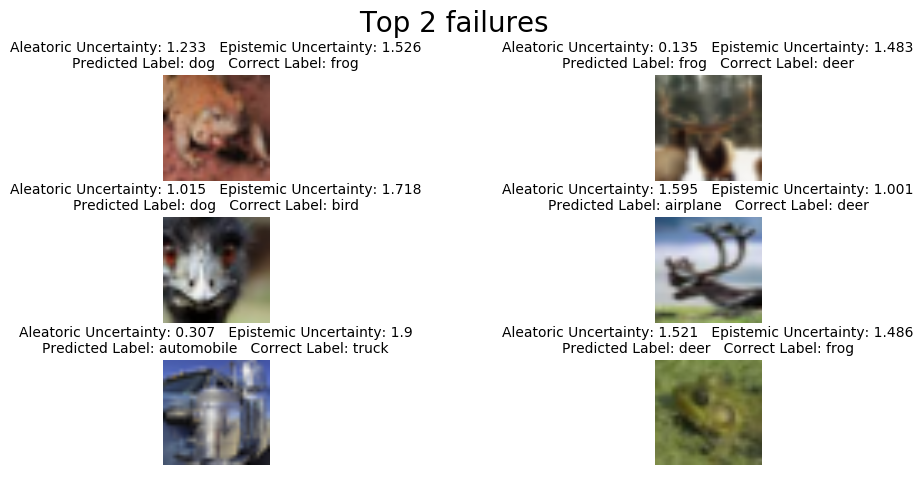

In [11]:
display_k("Top 2 failures", 
          test_images[top_2_failures_test], 
          [test_results[i] for i in top_2_failures_test])

In [12]:
max_epistemic_uncertainty_test = np.argsort([x['epistemic_uncertainty'] for x in test_results])[-8:]
max_aleatoric_uncertainty_test = np.argsort([x['aleatoric_uncertainty'] for x in test_results])[-40:]

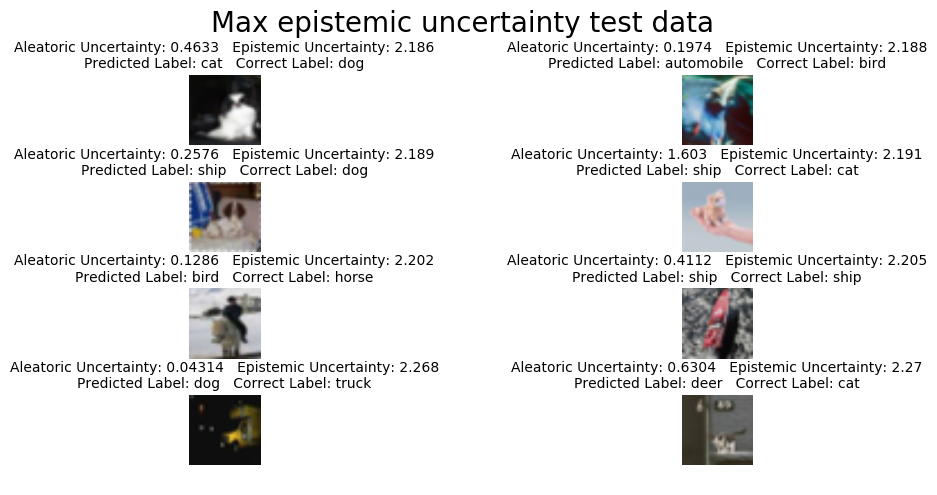

In [13]:
display_k("Max epistemic uncertainty test data", test_images[max_epistemic_uncertainty_test], 
          [test_results[i] for i in max_epistemic_uncertainty_test], file_name="blog_images/max_epistemic_uncertainty_test.png")

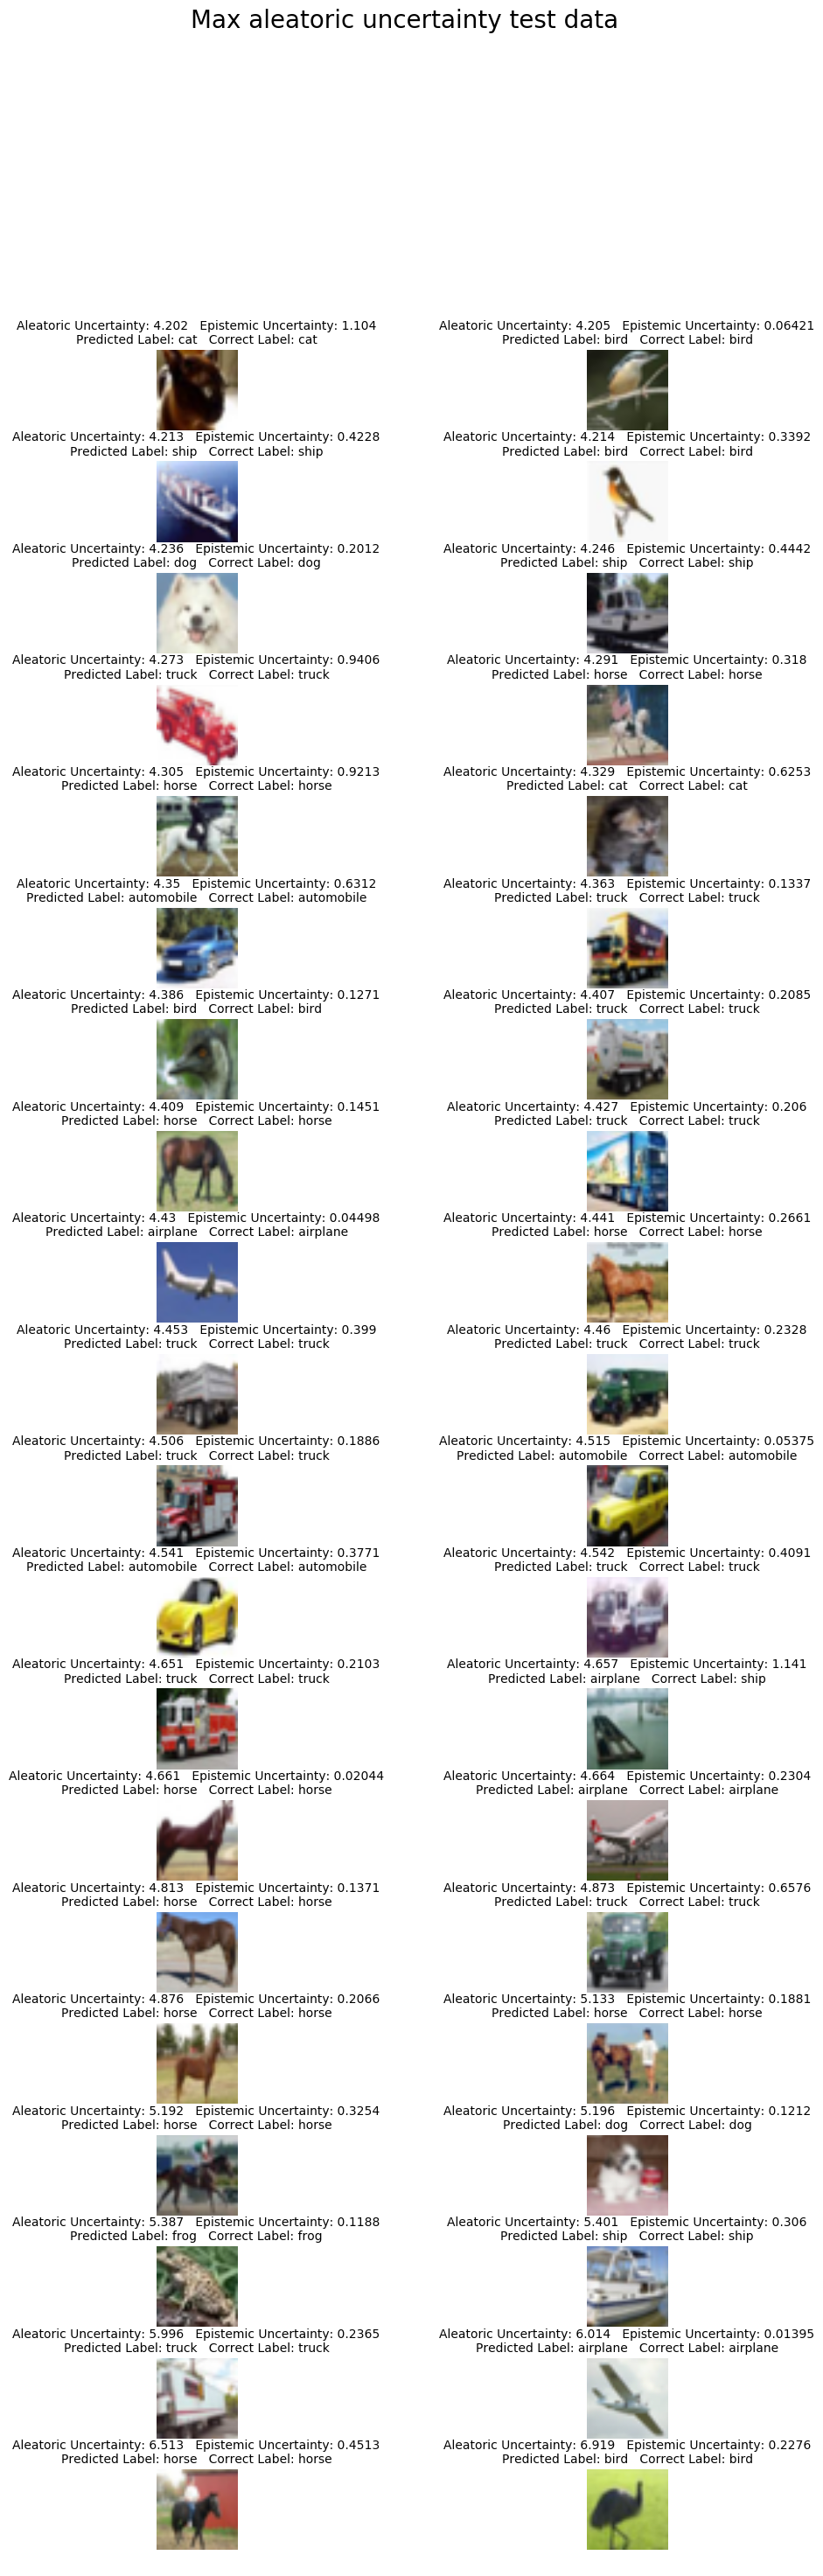

In [14]:
display_k("Max aleatoric uncertainty test data", test_images[max_aleatoric_uncertainty_test], 
          [test_results[i] for i in max_aleatoric_uncertainty_test], figsize=(10,30))
          #, file_name="blog_images/max_aleatoric_uncertainty_test.png")

In [15]:
[(test_results[i]['logits_raw'], test_results[i]['aleatoric_uncertainty']) for i in max_aleatoric_uncertainty_test]

[(array([-5.56904173,  0.57191366,  2.65884423,  7.95077515, -2.21093059,
         -0.10063241, -1.21199775,  3.76083183,  1.13663375, -3.53025246], dtype=float32),
  4.2019782),
 (array([  4.58156252,  -0.89383149,  11.55901241,  -4.61483812,
          -1.89834225,  -1.92624116,   2.19737387,   1.47857428,
          -1.61776042,  -1.46659493], dtype=float32), 4.2053876),
 (array([ 1.66056931,  2.33151674, -3.54403996, -3.56665707, -1.94449568,
         -2.16576123, -0.81762481, -0.79244286,  9.02880955,  1.92627037], dtype=float32),
  4.213325),
 (array([-0.91410804, -0.88009506,  8.31262589, -0.03973643, -3.3960793 ,
         -1.273422  ,  0.9746719 , -0.76703012,  1.12581885, -2.5463953 ], dtype=float32),
  4.2143111),
 (array([-0.6226638 , -0.06574361,  2.12305617,  4.16793537, -1.49319029,
          9.15798283,  0.13774261,  4.42067909, -0.21895756, -3.02554035], dtype=float32),
  4.2361498),
 (array([ 1.41902578,  4.81150436, -3.03092909, -5.05321407, -3.91626334,
         -3.438

In [16]:
def stats(name, results):
  return [name, np.max(results),np.min(results),np.mean(results),np.std(results)]

def build_dataframe(rows):
  return pd.DataFrame(data=rows, columns=['type', 'max', 'min', 'mean', 'std'])

def stats_df(results, keys):
  rows = []
  for key in keys:
    rows.append(stats(key, [x[key] for x in results]))
  return build_dataframe(rows)

test_stats = stats_df(test_results, ['aleatoric_uncertainty', 'epistemic_uncertainty'])
test_stats

,type,max,min,mean,std
0,aleatoric_uncertainty,6.918743,0.001534,0.780128,0.742645
1,epistemic_uncertainty,2.269879,0.013947,0.868012,0.525739


In [17]:
def right_wrong(results):
  right = [x for x in results if x['is_correct']]
  wrong = [x for x in results if x['is_correct'] == False]
  
  return (right, wrong)

def join_df(dfs):  
  result = pd.DataFrame(columns=dfs[0][0].columns)
  for i in range(len(dfs[0][0])):
    for df in dfs:
      df[0].iloc[i, 0] = df[1] + '_' + df[0].iloc[i, 0]
      result = result.append(df[0].iloc[i])
    
  return result

In [18]:
(right_train, wrong_train) = right_wrong(train_results)
(right_test, wrong_test) = right_wrong(test_results)

In [19]:
first_position = stats_df(by_logit_position[-1], ['aleatoric_uncertainty', 'epistemic_uncertainty'])
second_position = stats_df(by_logit_position[-2], ['aleatoric_uncertainty', 'epistemic_uncertainty'])
third_position = stats_df(by_logit_position[-3], ['aleatoric_uncertainty', 'epistemic_uncertainty'])
rest_positions = stats_df(np.concatenate(by_logit_position[0:-3]), ['aleatoric_uncertainty', 'epistemic_uncertainty'])

In [20]:
right_test_stats = stats_df(right_test, ['aleatoric_uncertainty', 'epistemic_uncertainty'])
wrong_test_stats = stats_df(wrong_test, ['aleatoric_uncertainty', 'epistemic_uncertainty'])

test_right_wrong_stats = join_df([(right_test_stats, 'right'), (wrong_test_stats, 'wrong')])
test_right_wrong_stats

,type,max,min,mean,std
0,right_aleatoric_uncertainty,6.918743,0.001534,0.812486,0.773752
0,wrong_aleatoric_uncertainty,4.656710,0.008754,0.672708,0.616370
1,right_epistemic_uncertainty,2.205333,0.013947,0.724187,0.470947
1,wrong_epistemic_uncertainty,2.269879,0.092272,1.345460,0.401324


In [21]:
first_second_rest_stats = join_df([(first_position, 'first_position'), (second_position, 'second_position'), (third_position, 'third_position'), (rest_positions, 'rest_positions')])
first_second_rest_stats

,type,max,min,mean,std
0,first_position_aleatoric_uncertainty,6.918743,0.001534,0.812486,0.773752
0,second_position_aleatoric_uncertainty,4.656710,0.008754,0.699073,0.646187
0,third_position_aleatoric_uncertainty,3.450918,0.034286,0.656728,0.576544
0,rest_positions_aleatoric_uncertainty,3.760101,0.019045,0.622656,0.572585
1,first_position_epistemic_uncertainty,2.205333,0.013947,0.724187,0.470947
1,second_position_epistemic_uncertainty,2.269879,0.199130,1.221626,0.390238
1,third_position_epistemic_uncertainty,2.142065,0.092272,1.400608,0.346418
1,rest_positions_epistemic_uncertainty,2.268070,0.248046,1.599792,0.341832


In [22]:
def stats_by_class(results, keys):
  class_stats = [[[] for k in keys] for _ in categories]
  for x in results:
    for k in range(len(keys)):
      label = x['label']
      row = class_stats[label][k]
      class_value = x[keys[k]]
      row.append(class_value)
  
  name = lambda k, i: "{}_{}".format(categories[i]['label_name'], keys[k])
  rows = []
  for k in range(len(keys)):
    for i in range(len(categories)):
      rows.append(stats(name(k, i), class_stats[i][k]))

  return build_dataframe(rows)


train_class_stats = stats_by_class(train_results, ['epistemic_uncertainty', 'aleatoric_uncertainty'])
test_class_stats = stats_by_class(test_results, ['epistemic_uncertainty', 'aleatoric_uncertainty'])


In [23]:
test_class_stats

,type,max,min,mean,std
0,airplane_epistemic_uncertainty,2.182363,0.013947,0.880538,0.548612
1,automobile_epistemic_uncertainty,2.131246,0.039494,0.628844,0.453998
2,bird_epistemic_uncertainty,2.187524,0.028681,0.916417,0.558411
3,cat_epistemic_uncertainty,2.269879,0.096830,1.176419,0.493026
4,deer_epistemic_uncertainty,2.137157,0.074383,1.082997,0.447171
5,dog_epistemic_uncertainty,2.189283,0.028162,0.886363,0.532533
6,frog_epistemic_uncertainty,2.119746,0.018844,0.804215,0.510137
7,horse_epistemic_uncertainty,2.202425,0.015233,0.848758,0.533589
8,ship_epistemic_uncertainty,2.205333,0.041998,0.742219,0.462328
9,truck_epistemic_uncertainty,2.268070,0.039414,0.713348,0.462829


In [24]:
right_test_class_stats = stats_by_class(right_test, ['epistemic_uncertainty', 'aleatoric_uncertainty'])
wrong_test_class_stats = stats_by_class(wrong_test, ['epistemic_uncertainty', 'aleatoric_uncertainty'])

In [25]:
test_right_wrong_class_stats = join_df([(right_test_class_stats, 'right'), (wrong_test_class_stats, 'wrong')])
test_right_wrong_class_stats

,type,max,min,mean,std
0,right_airplane_epistemic_uncertainty,2.085734,0.013947,0.711025,0.484399
0,wrong_airplane_epistemic_uncertainty,2.182363,0.326551,1.378399,0.404391
1,right_automobile_epistemic_uncertainty,2.101228,0.039494,0.551011,0.407269
1,wrong_automobile_epistemic_uncertainty,2.131246,0.348561,1.123311,0.422859
2,right_bird_epistemic_uncertainty,2.071393,0.028681,0.736511,0.513874
2,wrong_bird_epistemic_uncertainty,2.187524,0.234151,1.372221,0.378229
3,right_cat_epistemic_uncertainty,2.025855,0.096830,1.003878,0.484895
3,wrong_cat_epistemic_uncertainty,2.269879,0.271727,1.449720,0.365815
4,right_deer_epistemic_uncertainty,2.063101,0.074383,0.969961,0.422131
4,wrong_deer_epistemic_uncertainty,2.137157,0.342777,1.376567,0.370305


In [26]:
import os
import subprocess
# requires imagemagick and latex command line tools

def save_dataframe(df, path, file, columns=['type', 'mean', 'std']):
  tex_file = file + '.tex'
  pdf_file = file + '.pdf'
  png_file = path + "/" + file + '.png'
  log_file = file + '.log'
  aux_file = file + '.aux'
  
  l = df.to_latex(columns=columns,  index=False, float_format=lambda x: '%.4f' % x )
  template = r'''\documentclass[preview]{{standalone}}
  \usepackage{{booktabs}}
  \begin{{document}}
  {}
  \end{{document}}
  '''
  with open(tex_file,'w') as f:
    f.write(template.format(l))

  subprocess.call(['pdflatex', tex_file])
  subprocess.call(['convert', '-density', '500', pdf_file, '-quality', '90', png_file])
  
  os.remove(tex_file)
  os.remove(pdf_file)
  os.remove(log_file)
  os.remove(aux_file)

In [27]:
# save_dataframe(test_stats, 'blog_images', 'test_stats')
# save_dataframe(test_right_wrong_stats, 'blog_images', 'test_right_wrong_stats')
# save_dataframe(test_class_stats, 'blog_images', 'test_class_stats')
# save_dataframe(test_right_wrong_class_stats, 'blog_images', 'test_right_wrong_class_stats')
# save_dataframe(first_second_rest_stats, 'blog_images', 'test_first_second_rest_stats')


In [28]:
df = pd.DataFrame([[r['epistemic_uncertainty'], r['aleatoric_uncertainty']] for r in test_results], columns=['epistemic_uncertainty', 'aleatoric_uncertainty'])

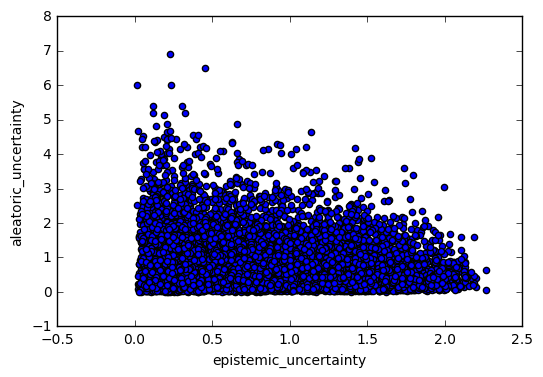

In [29]:
plt.figure()
df.plot(x='epistemic_uncertainty', y='aleatoric_uncertainty', kind='scatter')
plt.show()

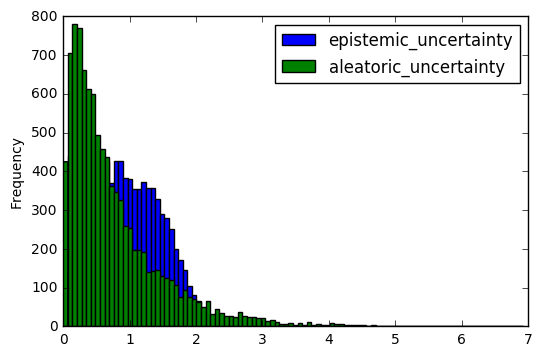

In [30]:
plt.figure()
df.plot.hist(stacked=False, bins=100)
plt.show()

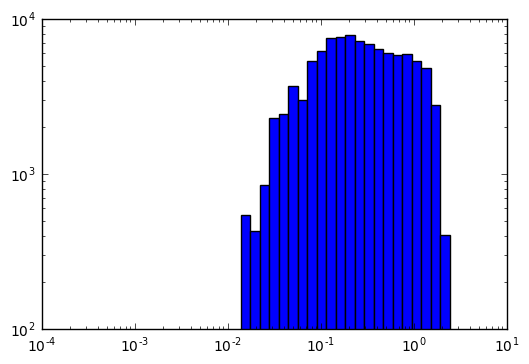

In [31]:
# log-scaled bins
bins = np.logspace(-4., 1.0, 50)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
hist = np.histogram(df['epistemic_uncertainty'], bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

plt.bar(bins[:-1], hist_norm, widths)
plt.xscale('log')
plt.yscale('log')
plt.show()

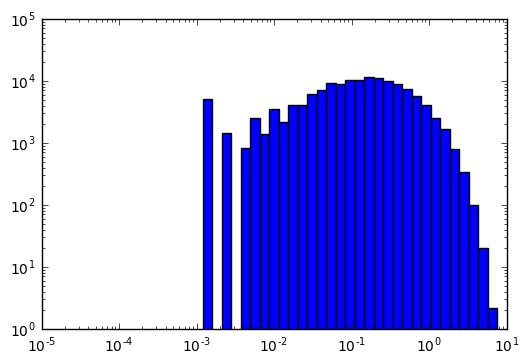

In [32]:
# log-scaled bins
bins = np.logspace(-5., 1.0, 50)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
hist = np.histogram(df['aleatoric_uncertainty'], bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

plt.bar(bins[:-1], hist_norm, widths)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [33]:
(_, (x_test, y_test)) = test_train_data('cifar10', (197, 197), True)
batch_size = 1
verbose = 0 
epistemic_monte_carlo_simulations = 1
debug = True 
full_model = True
encoder = 'resnet50'
dataset = 'cifar10'
model_batch_size = 256
model_epochs = 200
model_monte_carlo_simulations = 100
include_epistemic_uncertainty=False

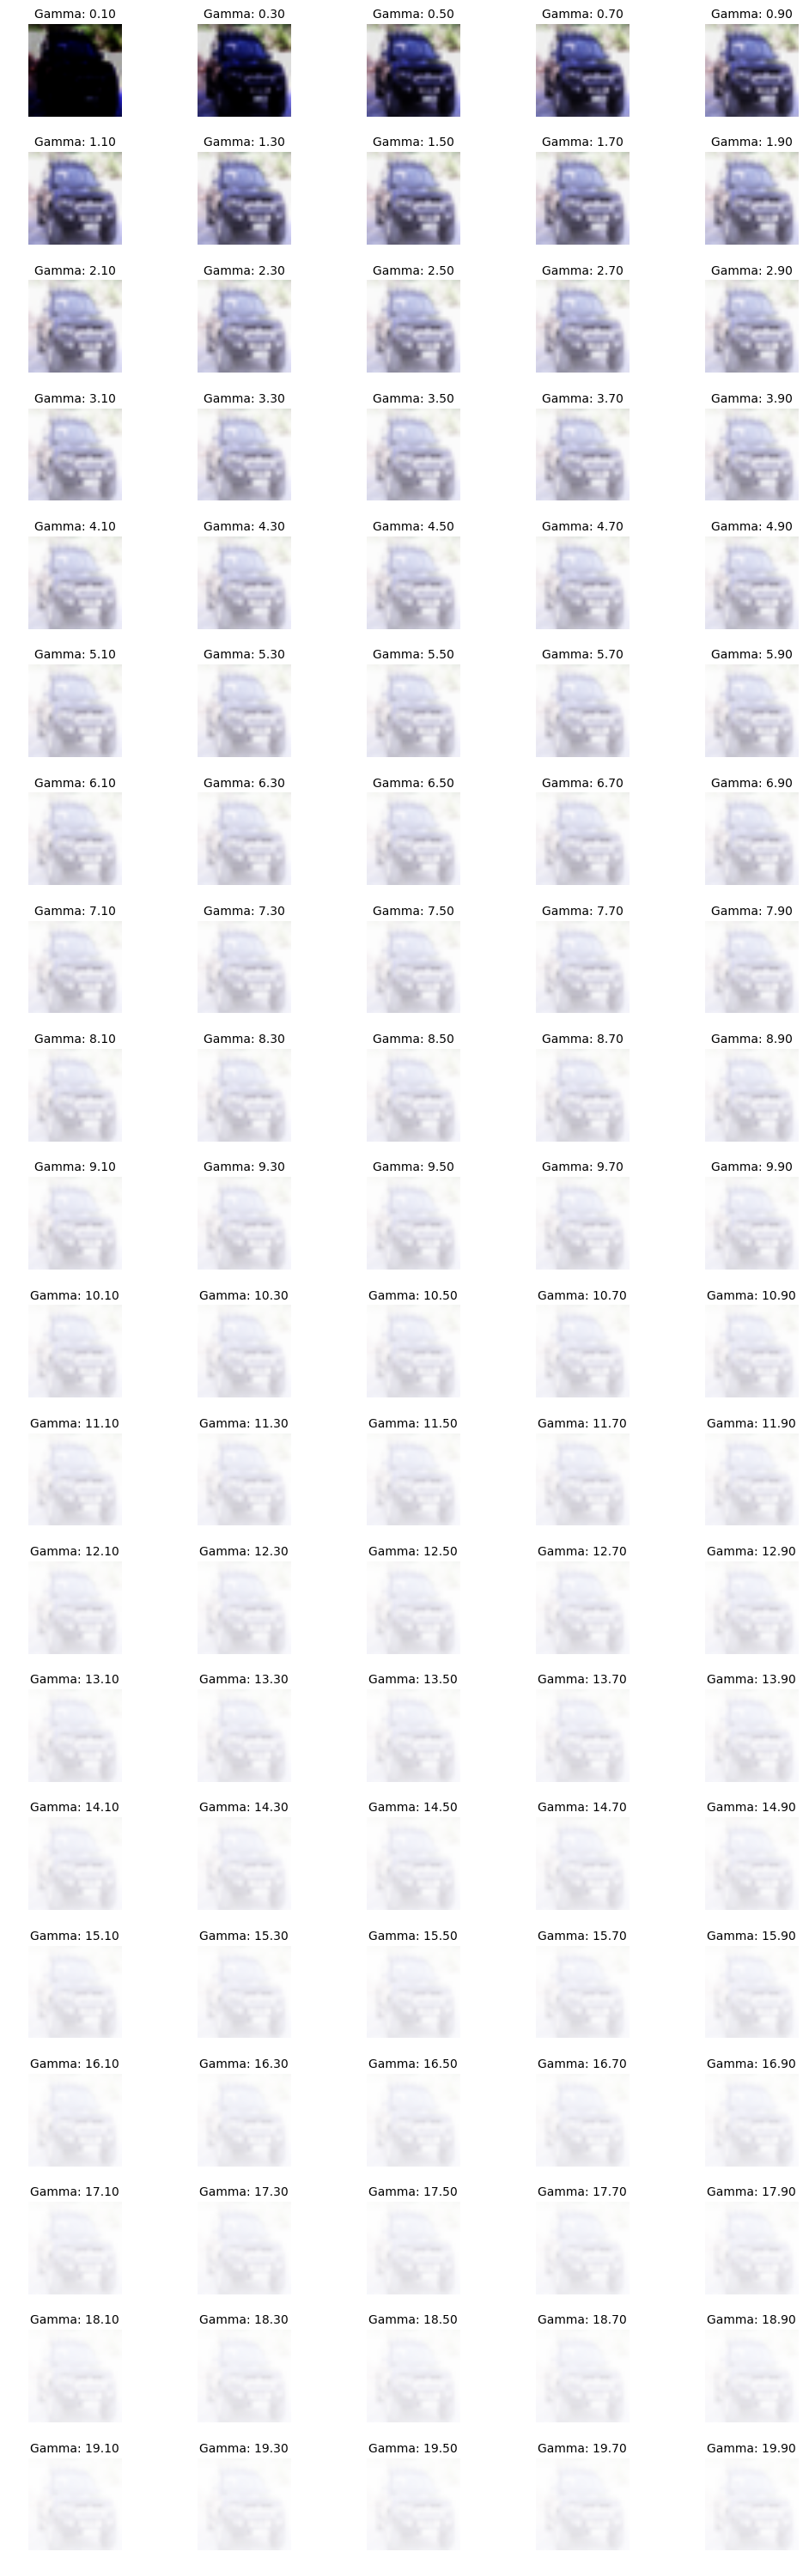

In [34]:
def display_gammas(image, gammas):
  f, axes = plt.subplots(int(len(gammas)/5), 5, figsize=(10, 30))
  f.tight_layout()
  
  axes = np.reshape(axes, -1)
  
  for i in range(len(axes)):
    g_image = augment_gamma([image], gammas[i])[0]
    axes[i].imshow(g_image)
    axes[i].set_title('Gamma: {0:.2f}'.format(gammas[i]), fontsize=10)
    axes[i].axis('off')
#   plt.savefig('blog_images/gammas.png')
  plt.show()
display_gammas(test_images[9], [0.1 + i/5. for i in range(100)])

In [35]:
print(test_images[0].shape)
print(y_test[0].shape)

(32, 32, 3)
(10,)


In [36]:
from keras.applications.resnet50 import preprocess_input

gammas = [0.5, 5.0]
augmented_images = np.reshape([augment_gamma(test_images[0:100], gamma) for gamma in gammas], (-1, 32, 32, 3))
augmented_labels = np.reshape([y_test[0:100] for _ in gammas], (-1, 10))

augmented_preprocessed_images = np.array([cv2.resize(i, (197, 197)) for i in augmented_images], dtype="float64")
augmented_preprocessed_images = preprocess_input(augmented_preprocessed_images)

In [37]:
from bnn.predict import predict_on_data

augmented_results = predict_on_data(batch_size, verbose, epistemic_monte_carlo_simulations, debug, full_model,
                augmented_preprocessed_images[0:1], augmented_labels[0:1], augmented_preprocessed_images, augmented_labels,
                encoder, dataset, model_batch_size, model_epochs, model_monte_carlo_simulations, True)[1]

/Users/kyledorman/anaconda/lib/python3.5/site-packages/keras/models.py:277: UserWarning: Output "softmax_output" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "softmax_output" during training.
  sample_weight_mode=sample_weight_mode)


Predicting epistemic_uncertainties.
Compiling full testable model.


/Users/kyledorman/Documents/carnd/bayesian-neural-network-blogpost/bnn/predict.py:21: UserWarning: Output "softmax_output" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "softmax_output" during training.
  metrics={'softmax_output': ['categorical_accuracy', 'top_k_categorical_accuracy']})


Predicting softmax and aleatoric_uncertainties.


In [56]:
a = np.zeros((11,10))
for i in range(np.min(a.shape)):
  a[i][i] = 1
b = np.reshape(np.arange(11), (1,-1))
print(b)
np.dot(b, a)

[[ 0  1  2  3  4  5  6  7  8  9 10]]


array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]])

In [38]:
accuracy(augmented_results)

0.115

In [39]:
stats_df(augmented_results, ['aleatoric_uncertainty'])

,type,max,min,mean,std
0,aleatoric_uncertainty,0.086698,0.056383,0.069768,0.005398


In [40]:
augmented_logit_position, _ = results_by_logit_position(augmented_results)

for i in range(len(augmented_logit_position)):
  print(i, ":", len(augmented_logit_position[i]))

0 : 14
1 : 23
2 : 25
3 : 23
4 : 17
5 : 22
6 : 18
7 : 17
8 : 18
9 : 23


In [41]:
max_augmented_aleatoric_uncertainty_test = np.argsort([x['aleatoric_uncertainty'] for x in augmented_results])[-8:]
image_idx = max_augmented_aleatoric_uncertainty_test % 100

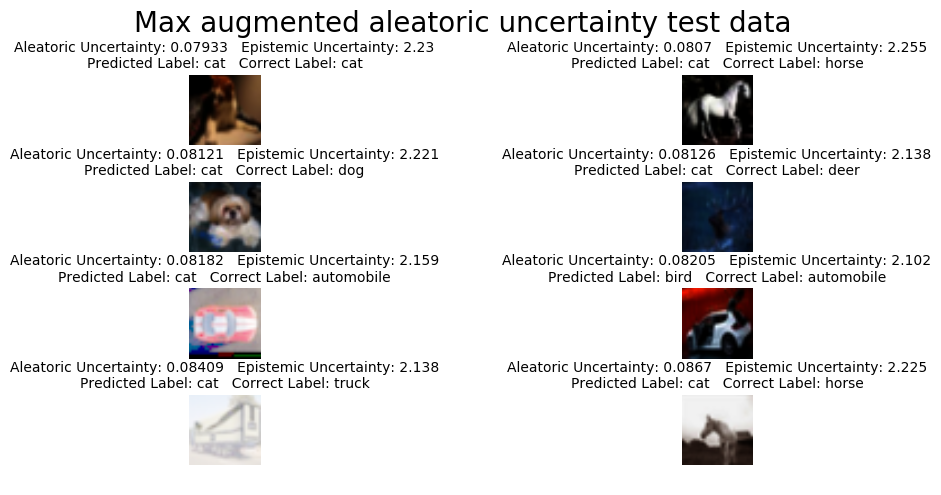

In [42]:
display_k("Max augmented aleatoric uncertainty test data", augmented_images[max_augmented_aleatoric_uncertainty_test], 
          [augmented_results[i] for i in max_augmented_aleatoric_uncertainty_test])

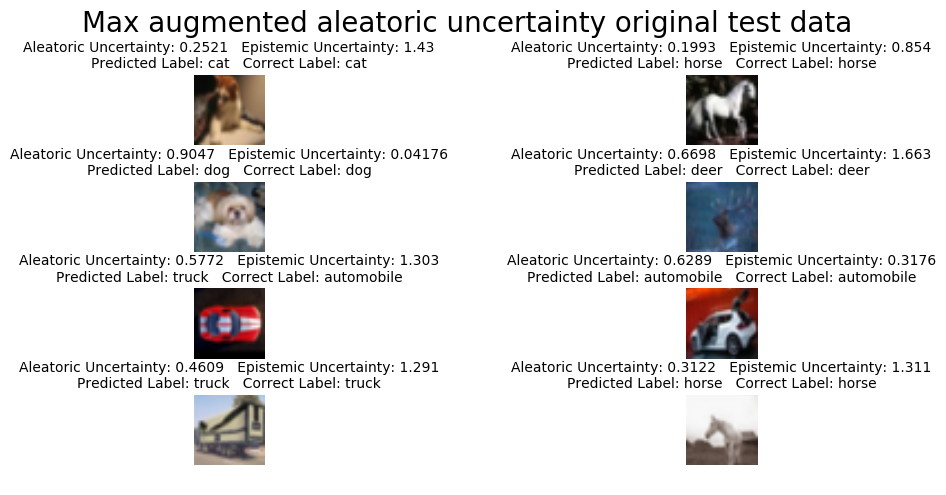

In [43]:
display_k("Max augmented aleatoric uncertainty original test data", test_images[image_idx], 
          [test_results[i] for i in image_idx])